In [1]:
#import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

%matplotlib inline

#import conviction files
#from conviction_helpers import *
#from conviction_system_logic3 import *
from bonding_curve_eq import *

System initialization

In [2]:
hatch_raise = 100000 # fiat units
hatch_price = .1 #fiat per tokens
theta = .5 #share of funds going to funding pool at launch

R0 = hatch_raise*(1-theta)
F0 = hatch_raise*theta
S0 = hatch_raise/hatch_price

kappa = 4
V0 = invariant(R0,S0,kappa)
P0 = spot_price(R0, V0, kappa)

dust = 10**-8

agent initialization

In [3]:
#number of agents
n= 100

#gain factors
g = np.random.normal(2, .5, size=n)
phat0 = g*F0/S0 #derivative, integral and proportion
#agents as controllers, co-steering

#wakeup rates
gamma =  sts.expon.rvs(loc=1,scale=5, size=n)

#holdings fiat
h = sts.expon.rvs( loc=100,scale=1000, size=n)

#holdings tokens
s_dist = sts.expon.rvs(loc=10, scale=10, size=n)
s0 = s_dist/sum(s_dist)*S0

#lambda for revenue process
lam = 200

#phi for exiting funds
phi = .05

#beta is param for armijo rule
beta = .9

(array([35., 17., 14., 14.,  8.,  0.,  4.,  4.,  2.,  2.]),
 array([ 1.00320027,  3.24360193,  5.4840036 ,  7.72440526,  9.96480692,
        12.20520859, 14.44561025, 16.68601192, 18.92641358, 21.16681525,
        23.40721691]),
 <a list of 10 Patch objects>)

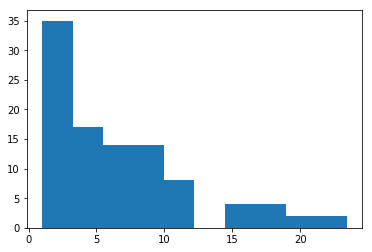

In [4]:
plt.hist(gamma)

In [5]:
params= {
    'kappa': [kappa],
    'lambda': [lam],
    'gains': [g],
    'rates':[1/gamma],
    'population':[n],
    'beta':[beta],
    'phi': [phi],
    'invariant': [V0],
    'dust' : [dust]}

In [6]:
initial_conditions = {'holdings': h,
                      'tokens': s0,
                      'supply': S0,
                      'prices': phat0,
                      'funds':F0,
                      'reserve': R0,
                      'spot_price': P0,
                      'actions': {}}

In [7]:
initial_conditions

{'actions': {},
 'funds': 50000.0,
 'holdings': array([ 154.73765045,  502.96265376, 1693.90924367,  775.44690856,
         894.55808457,  644.86523757,  708.52400572, 1437.59009134,
         537.71189858,  274.43916758,  492.67369288,  391.90535758,
        1071.82222873,  465.94066865,  278.51396621, 2572.7021714 ,
         185.15675026,  429.50606309,  445.91601201, 1323.74521866,
         454.3401318 , 1522.6252209 , 4986.23576439,  645.56022439,
        1768.31682209,  239.75982482, 2028.58063911,  467.57443491,
        3247.24473635, 3236.91068432, 1467.74118084,  199.24795827,
         159.06129453,  369.89047044, 2867.89106393, 1418.10437073,
         775.51148829,  859.30777879, 4729.95481298,  983.67170402,
         364.73703018,  623.58758958,  112.66696766,  441.38052406,
        3697.38333854,  120.91013273, 2656.72766161, 1973.84798995,
         651.54297467, 2344.62993192,  448.54569332,  551.36796892,
         402.03516068,  725.09745262, 1422.06413268, 2067.50593915,
 

In [8]:
#change in F (revenue and spending accounted for)
def revenue_process(params, step, sL, s):
    lam = params['lambda']
    rv = sts.expon.rvs(loc = 0, scale=1/lam)
    delF= 1-1/lam+rv
    
    #avoid the crash (temporary hacks, tune martingale process better)
    #if delF <1:
    #    if s['funds'] <1000:
    #        delF =100
    
    return({'delF':delF})

In [9]:
def update_funds(params, step, sL, s, _input):
    
    funds = s['funds']*_input['delF']
    
    key = 'funds'
    value = funds
    
    return (key, value)

In [10]:
def update_prices(params, step, sL, s, _input):
    
    g = params['gains']
    phat = g*s['funds']/s['supply']
    
    key = 'prices'
    value = phat
    
    return (key, value)

In [11]:
#change in F (revenue and spending accounted for)
def choose_agents(params, step, sL, s):
    n = params['population']
    rates = params['rates']
    
    agents = []
    for a in range(n):
        sq_gap = (s['spot_price']-s['prices'][a])**2
        pr = (rates[a]+sq_gap)/(1+sq_gap) #rates when sq_gap =0, 1 when sq_gap -> infty
        rv = np.random.rand()
        if rv < pr:
            agents.append(a)
    
    #shuffle
    shuffled_agents =np.random.choice(agents,len(agents), False)     
        
    return({'agents':shuffled_agents})

In [12]:
def agent_actions(params, step, sL, s, _input):
    
    R = s['reserve']
    S = s['supply']
    F = s['funds']
    V0 = params['invariant']
    P=s['spot_price']
    
    actions = []
    for a in _input['agents']:
        h_a = s['holdings'][a]
        phat_a = s['prices'][a]
        s_a =  s['tokens'][a]
        beta = params['beta']

        if P>phat_a: #equiv: pbar(0)>phat_a
            mech = 'burn'
                        
            #approx for burn s.t. p=phat
            #armijo style
            amt = s_a
            
            def pbar(amt):
                output = withdraw_with_tax(amt, R,S, V0, params['phi'], params['kappa'])

                if not(output[2])>0:
                    return np.Infinity
                else:
                    return output[2]

            if amt > 10**-8:
                while pbar(amt)< phat_a:
                    amt = amt*beta

        else: # P<phat_a; #equiv pbar(0)<phat_a
            mech = 'bond'
            #approx for buy s.t. p=phat
            #armijo style
            amt = h_a
  
            def pbar(amt):
                output = mint(amt, R,S, V0, params['kappa'])

                if not(output[1])>0:
                    return 0
                else:
                    return output[1]
                
            if amt > params['dust']:
                while pbar(amt)> phat_a:
                    amt = amt*beta
        
        action = {'agent':a, 'mech':mech, 'amt':amt, 'pbar':pbar(amt),'posterior':{}}
        
        if action['mech'] == 'bond':
            h_a = h_a-amt
            dS, pbar = mint(amt, R,S, V0, params['kappa'])
            R = R+amt
            S = S+dS
            s_a = s_a+dS
            P = spot_price(R, V0, kappa)
    
        elif action['mech'] == 'burn':
            s_a = s_a-amt
            dR, pbar = withdraw(amt, R,S, V0, params['kappa'])
            R = R-dR
            F = F + params['phi']*dR
            S = S-amt
            h_a = h_a + (1-params['phi'])*dR
            P = spot_price(R, V0, kappa)
        
        action['posterior'] = {'F':F, 'S':S, 'R':R,'P':P, 'a':a,'s_a':s_a, 'h_a':h_a}
        actions.append(action)
        
    key = 'actions'
    value = actions
    
    return (key, value)

In [13]:
def resolve_actions(params, step, sL, s):
    
    H_a = s['holdings']
    S_a =  s['tokens']
    
    actions = s['actions']
    
    for action in actions:
        a= action['agent']
        H_a[a] = action['posterior']['h_a']
        S_a[a] = action['posterior']['s_a']
    
    #last action only
    F = action['posterior']['F']
    R = action['posterior']['R']
    P = action['posterior']['P']
    S = action['posterior']['S']
    
    return({'F':F, 'S':S, 'R':R,'P':P, 'S_a':S_a, 'H_a':H_a})

In [14]:
def update_F(params, step, sL, s, _input):
    
    F = _input['F']
    
    key = 'funds'
    value = F
    
    return (key, value)

def update_S(params, step, sL, s, _input):
    
    S = _input['S']
    
    key = 'supply'
    value = S
    
    return (key, value)

def update_R(params, step, sL, s, _input):
    
    R = _input['R']
    
    key = 'reserve'
    value = R
    
    return (key, value)

def update_P(params, step, sL, s, _input):
    
    P = _input['P']
    
    key = 'spot_price'
    value = P
    
    return (key, value)

def update_holdings(params, step, sL, s, _input):
    
    H_a = _input['H_a']
    
    key = 'holdings'
    value = H_a
    
    return (key, value)

def update_tokens(params, step, sL, s, _input):
    
    S_a = _input['S_a']
    
    sumS = np.sum(S_a)
    S = _input['S']
    
    tokens = S_a*S/sumS
    
    key = 'tokens'
    value = tokens
    
    return (key, value)

In [15]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    { 
        'policies': { 
            #new proposals or new participants
            'random': revenue_process
        },
        'variables': {
            'funds': update_funds,
            'prices': update_prices
        }
    },
    {
      'policies': {
          'random': choose_agents
        },
        'variables': { 
            'actions': agent_actions, 
        }
    },
    {
      'policies': {
          'act': resolve_actions,
        },
        'variables': {
            'funds': update_F, #
            'supply': update_S, 
            'reserve': update_R,
            'spot_price': update_P,
            'holdings': update_holdings,
            'tokens': update_tokens
        }
    }
]

In [16]:
time_periods_per_run = 1000
monte_carlo_runs = 1

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
})

In [17]:
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

[{'N': 1, 'T': range(0, 1000), 'M': {'kappa': 4, 'lambda': 200, 'gains': array([2.42747606, 2.68657347, 2.24454705, 1.49349326, 2.47379923,
       1.79099536, 1.31015956, 1.9257131 , 1.77824338, 2.10884522,
       1.69424958, 2.24576117, 1.27388507, 2.34611718, 2.1997394 ,
       0.9362    , 1.86597932, 1.62140001, 1.30964455, 1.86499098,
       2.1193762 , 2.78532497, 2.50831976, 2.72315591, 1.8531232 ,
       1.8452032 , 1.90844011, 1.35368092, 2.46874524, 1.98414263,
       1.9373424 , 2.52377657, 0.74483501, 1.77094288, 1.3588082 ,
       2.07673435, 1.56498416, 1.80123821, 2.15375431, 1.58017319,
       1.74453173, 1.60454664, 1.46358911, 1.37995706, 2.13240168,
       0.96347804, 3.37207745, 2.68927575, 1.13966534, 1.32478297,
       2.12492076, 2.03227932, 1.59281542, 2.48304719, 1.40838453,
       2.36356917, 1.08551054, 2.3107968 , 1.86409775, 1.68914768,
       2.51619398, 2.6902358 , 0.87757711, 1.25107168, 2.13211265,
       2.08072616, 1.75010318, 1.23874266, 2.60293834, 2

In [18]:
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs
import pandas as pd

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

In [19]:
i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1
    


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x1a1fdd46d8>]
Configurations: [<cadCAD.configuration.Configuration object at 0x1a1fdd46d8>]


/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:56: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = quantity_recieved/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:56: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = quantity_recieved/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:47: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:37: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS


In [20]:
experiment_index = 0
df = results[experiment_index]['result']

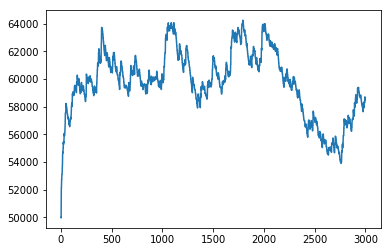

In [21]:
df.funds.plot()

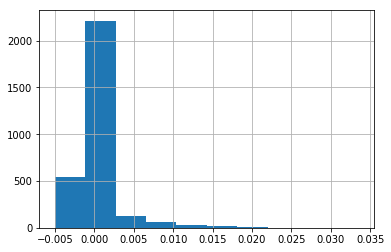

In [22]:
(df.funds.diff()/df.funds).hist()

In [23]:
rdf = df[df.substep == 3].copy()

In [24]:
rdf['token_wts'] = (rdf.tokens/rdf.supply)
rdf['wt_mean_price'] = (rdf.token_wts*rdf.prices).apply(sum)

In [25]:
rdf['holding_wts'] = (rdf.holdings/rdf.holdings.apply(sum))
rdf['h_wt_mean_price'] = (rdf.holding_wts*rdf.prices).apply(sum)

In [26]:
rdf['wealth'] = rdf.holdings + rdf.spot_price*rdf.tokens

In [27]:
rdf['wealth_wts'] = rdf.wealth/rdf.wealth.apply(sum)
rdf['w_wt_mean_price'] = (rdf.wealth_wts*rdf.prices).apply(sum)

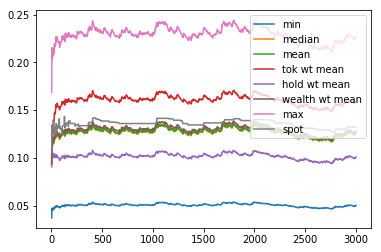

In [28]:
rdf.prices.apply(np.min).plot()
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.wt_mean_price.plot()
rdf.h_wt_mean_price.plot()
rdf.w_wt_mean_price.plot()
rdf.prices.apply(np.max).plot()
rdf.spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

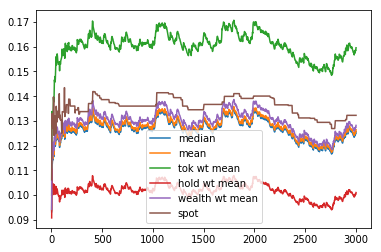

In [29]:
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.wt_mean_price.plot()
rdf.h_wt_mean_price.plot()
rdf.w_wt_mean_price.plot()
rdf.spot_price.plot()
plt.legend(['median','mean','tok wt mean','hold wt mean','wealth wt mean', 'spot'])

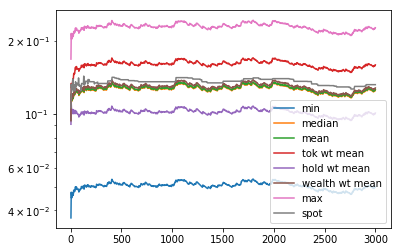

In [30]:
rdf.prices.apply(np.min).plot(logy=True)
rdf.prices.apply(np.median).plot(logy=True)
rdf.prices.apply(np.mean).plot(logy=True)
rdf.wt_mean_price.plot(logy=True)
rdf.h_wt_mean_price.plot(logy=True)
rdf.w_wt_mean_price.plot(logy=True)
rdf.prices.apply(np.max).plot(logy=True)
rdf.spot_price.plot(logy=True)
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

In [31]:
rdf['median_price']=rdf.prices.apply(np.median)
rdf['mean_price']=rdf.prices.apply(np.mean)

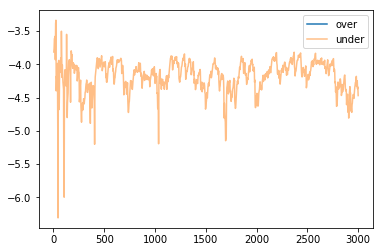

In [32]:
(np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=1)
(-np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=.5)
plt.legend(['over','under'])

In [33]:
rdf['est_err'] = rdf.spot_price - rdf.wt_mean_price
rdf['sq_est_err'] = rdf['est_err']**2

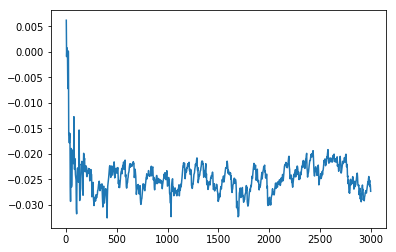

In [34]:
rdf.est_err.plot()

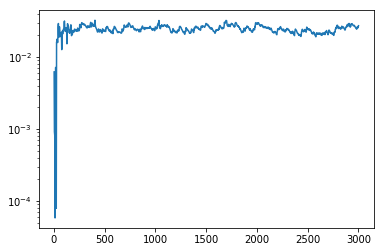

In [35]:
rdf.est_err.apply(np.abs).plot(logy=True)

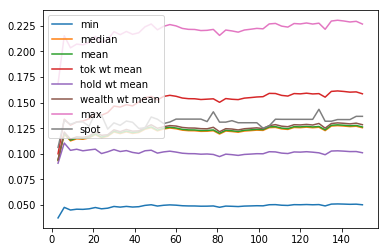

In [36]:
#head T
T = 50
rdf.head(T).prices.apply(np.min).plot()
rdf.head(T).prices.apply(np.median).plot()
rdf.head(T).prices.apply(np.mean).plot()
rdf.head(T).wt_mean_price.plot()
rdf.head(T).h_wt_mean_price.plot()
rdf.head(T).w_wt_mean_price.plot()
rdf.head(T).prices.apply(np.max).plot()
rdf.head(T).spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

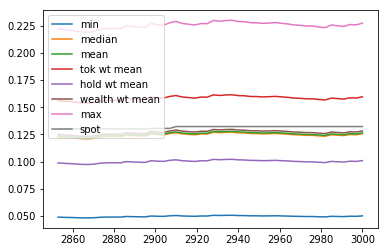

In [37]:
T = 50
rdf.tail(T).prices.apply(np.min).plot()
rdf.tail(T).prices.apply(np.median).plot()
rdf.tail(T).prices.apply(np.mean).plot()
rdf.tail(T).wt_mean_price.plot()
rdf.tail(T).h_wt_mean_price.plot()
rdf.tail(T).w_wt_mean_price.plot()
rdf.tail(T).prices.apply(np.max).plot()
rdf.tail(T).spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

In [38]:
tx_data = rdf.actions.values
transactions = []
states = []
for t in range(time_periods_per_run):
    for tx in range(len(tx_data[t])):
        states.append(tx_data[t][tx]['posterior'])
        transactions.append(tx_data[t][tx])


In [39]:
sdf = pd.DataFrame(states)
tdf = pd.DataFrame(transactions).drop('posterior', axis=1)

In [40]:
ind=tdf[tdf.amt==0].index
tdf.drop(ind, inplace=True)
sdf.drop(ind, inplace=True)

In [41]:
tx_summary=tdf[['agent','mech','pbar','amt']].groupby(['agent','mech']).agg(['median','count']).T.iloc[:-1].T

In [42]:
tx_summary

pbar                  amt
              median  count        median
agent mech                               
0     bond  0.133161    1.0  1.547377e+02
1     bond  0.123043    1.0  5.029627e+02
2     bond  0.138111    1.0  1.693909e+03
3     burn  0.119747    1.0  6.151929e+03
4     bond  0.119051    1.0  2.038364e+03
      burn  0.182353    1.0  6.272473e+03
5     burn  0.169431    1.0  7.734154e+03
6     burn  0.115476    1.0  6.782901e+03
7     bond  0.132960    2.0  6.251904e+02
      burn  0.136776   10.0  2.456796e-09
8     burn  0.107701    1.0  9.644793e+03
9     bond  0.127865    4.0  5.919352e+02
      burn  0.134434    4.0  3.504939e+03
10    burn  0.120321    1.0  5.326944e+03
11    bond  0.127692    1.0  3.919054e+02
12    burn  0.129883    1.0  5.922429e+03
13    bond  0.133065    1.0  1.354270e+03
      burn  0.127178    1.0  6.984934e+03
14    bond  0.131496    1.0  2.785140e+02
15    burn  0.125028    1.0  9.338761e+03
16    burn  0.119402    1.0  6.418437e+03
17    burn  0.128352    1.0  5.949967e+03
18    burn  0.124479    1.0  7.133448e+03
19    burn  0.124845    2.0  6.184748e+03
20    bond  0.132559    1.0  4.543401e+02
21    bond  0.119432    1.0  1.522625e+03
22    bond  0.117668    1.0  4.986236e+03
23    bond  0.132165    1.0  1.975753e+03
      burn  0.136230    1.0  9.764287e+03
24    burn  0.125968    1.0  5.472890e+03
...              ...    ...           ...
76    burn  0.141746    1.0  1.405609e+04
77    burn  0.122631    1.0  9.295744e+03
78    burn  0.120858    1.0  1.233323e+04
79    bond  0.132721   23.0  3.214154e-10
      burn  0.139691  119.0  5.443000e-10
80    burn  0.124794    1.0  1.404819e+04
81    bond  0.141008    1.0  1.401991e+03
82    burn  0.129557    1.0  6.119848e+03
83    burn  0.119729    1.0  1.373777e+04
84    burn  0.122472    1.0  2.180054e+04
85    bond  0.132596   33.0  4.216417e-10
      burn  0.136660  142.0  1.002178e-09
86    burn  0.127334    1.0  5.700426e+03
87    bond  0.128471    1.0  9.821480e+02
      burn  0.132346    1.0  7.834164e-10
88    bond  0.128923    1.0  1.047239e+03
89    bond  0.135554   17.0  2.481465e-09
      burn  0.134314  300.0  1.027454e-09
90    bond  0.107531    1.0  7.368720e+02
      burn  0.155436    2.0  8.018007e+03
91    burn  0.116157    1.0  1.735852e+04
92    bond  0.131763    1.0  5.135065e+02
93    burn  0.173536    1.0  7.687296e+03
94    bond  0.132353    1.0  7.478165e+02
95    bond  0.128866    1.0  6.338835e+02
96    bond  0.132912    1.0  5.444795e+02
97    bond  0.135208    1.0  1.584690e+02
98    burn  0.125645    1.0  6.069589e+03
99    bond  0.125424    3.0  3.895439e+02
      burn  0.124833    7.0  2.594568e+03

[120 rows x 3 columns]

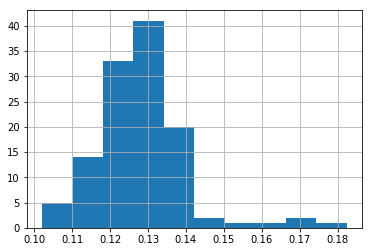

In [43]:
tx_summary.pbar['median'].hist()

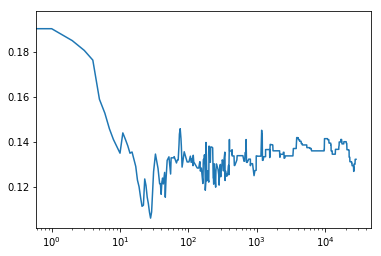

In [44]:
sdf['P'].plot(logx=True)

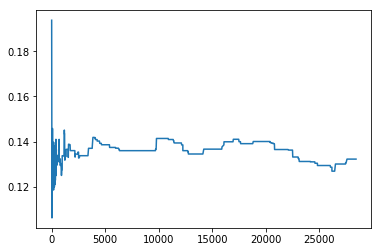

In [66]:
sdf['P'].plot()

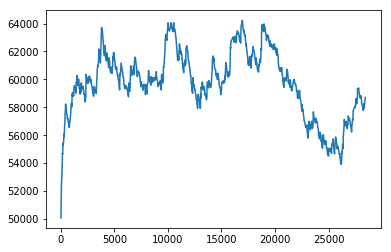

In [46]:
sdf.F.plot()

In [47]:
bond_amts = [tdf.iloc[k].amt for k in range(time_periods_per_run) if tdf.iloc[k].mech=='bond']
burn_amts = [tdf.iloc[k].amt for k in range(time_periods_per_run) if tdf.iloc[k].mech=='burn']

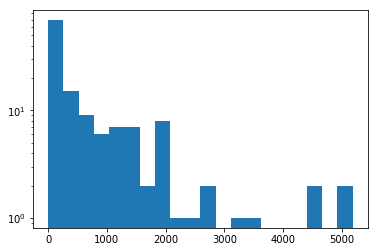

In [48]:
plt.hist(bond_amts, bins=20)
plt.yscale('log')

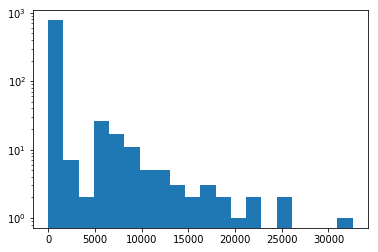

In [49]:
plt.hist(burn_amts, bins=20)
plt.yscale('log')

In [50]:
rdf['invariant'] = rdf.supply.apply(lambda x: x**kappa)/rdf.reserve

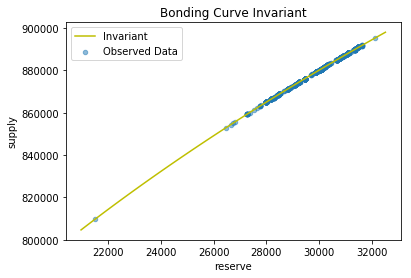

In [51]:
rdf.plot(x='reserve', y='supply', kind='scatter', alpha=.5)
axis = plt.axis()
xrange = np.arange(axis[0], axis[1], (axis[1]-axis[0])/100)
yrange = np.array([supply(x, V0, kappa) for x in xrange ])
plt.plot(xrange, yrange, 'y')
plt.title('Bonding Curve Invariant')
plt.legend(['Invariant', 'Observed Data'])

In [52]:
def gini(x):

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

(array([43.,  9., 13., 13.,  6.,  7.,  6.,  1.,  1.,  1.]),
 array([   0.        ,  598.84651177, 1197.69302353, 1796.5395353 ,
        2395.38604706, 2994.23255883, 3593.07907059, 4191.92558236,
        4790.77209412, 5389.61860589, 5988.46511766]),
 <a list of 10 Patch objects>)

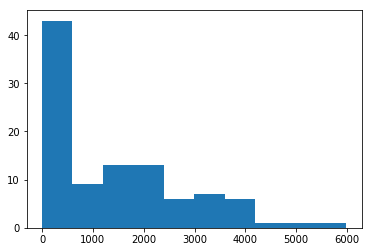

In [53]:
plt.hist(rdf.iloc[-1].holdings)

In [54]:
rdf['gini_h'] = rdf.holdings.apply(gini)

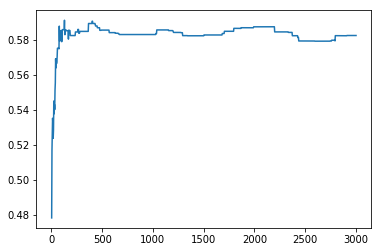

In [55]:
rdf.gini_h.plot()

(array([57., 22., 10.,  4.,  4.,  2.,  0.,  0.,  0.,  1.]),
 array([    0.        ,  7706.19515479, 15412.39030957, 23118.58546436,
        30824.78061915, 38530.97577393, 46237.17092872, 53943.3660835 ,
        61649.56123829, 69355.75639308, 77061.95154786]),
 <a list of 10 Patch objects>)

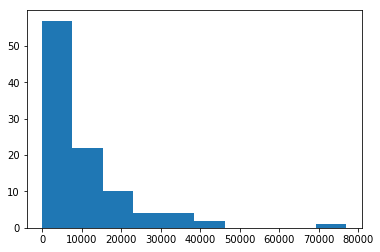

In [56]:
plt.hist(rdf.iloc[-1].tokens)

In [57]:
rdf['gini_s'] = rdf.tokens.apply(gini)

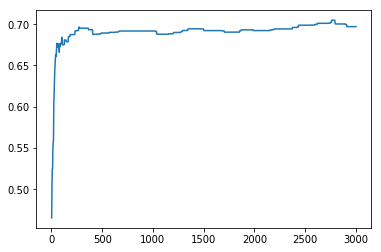

In [58]:
rdf.gini_s.plot()

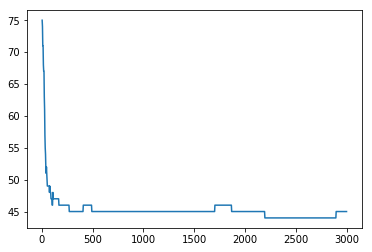

In [59]:
rdf.tokens.apply(np.count_nonzero).plot()

In [60]:
rdf['asset_value'] = rdf.holdings + rdf.spot_price*rdf.tokens

(array([32., 33., 17., 11.,  3.,  3.,  0.,  0.,  0.,  1.]),
 array([  719.94368949,  1667.02664053,  2614.10959157,  3561.19254262,
         4508.27549366,  5455.3584447 ,  6402.44139575,  7349.52434679,
         8296.60729784,  9243.69024888, 10190.77319992]),
 <a list of 10 Patch objects>)

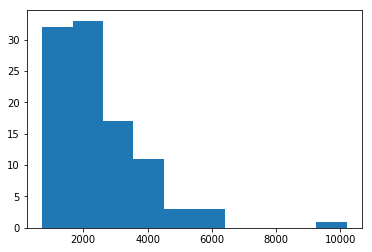

In [61]:
plt.hist(rdf.iloc[-1].asset_value)

In [62]:
rdf['gini'] = rdf.asset_value.apply(gini)

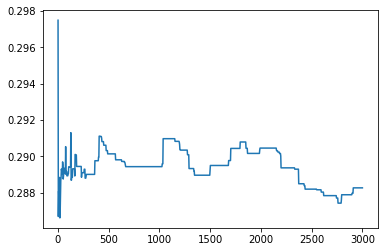

In [63]:
rdf.gini.plot()

In [64]:
rdf['pref_gap'] = (rdf.prices - rdf.spot_price)/rdf.spot_price

([array([ 7., 17., 29., 26., 13.,  7.,  1.]),
  array([ 7., 17., 28., 26., 14.,  7.,  1.]),
  array([ 7., 17., 28., 27., 13.,  7.,  1.]),
  array([ 7., 17., 29., 26., 13.,  7.,  1.]),
  array([ 7., 17., 28., 26., 14.,  7.,  1.]),
  array([ 7., 17., 28., 26., 14.,  7.,  1.]),
  array([ 7., 16., 26., 27., 16.,  7.,  1.])],
 array([-0.62734788, -0.43510644, -0.242865  , -0.05062356,  0.14161788,
         0.33385931,  0.52610075,  0.71834219]),
 <a list of 7 Lists of Patches objects>)

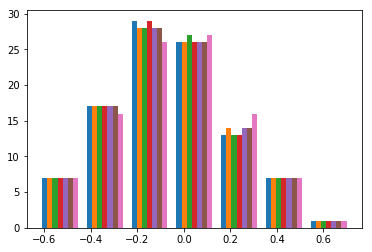

In [65]:
plt.hist(rdf.iloc[-7:].pref_gap, bins=7)